In [117]:
import pandas as pd
from sklearn import feature_selection, metrics
import sklearn
import matplotlib.pyplot as plt
import xgboost as xgb

In [34]:
enh_df = pd.read_csv("enh_feature.tsv", sep="\t").filter(regex=("chrom|start|end|RPKM"), axis=1)
pro_df = pd.read_csv("pro_feature.tsv", sep="\t").filter(regex=("chrom|start|end|RPKM"), axis=1)
ABC_rep_df = pd.read_csv("EPCrisprBenchmark_ensemble_data_GRCh38.K562_ActivityOnly_features_NAfilled.tsv", sep="\t")
ENFORMER_df = pd.read_csv("ENFORMER_output_0.tsv", sep="\t", index_col=0)

In [17]:
# check we didn't fuck up the order of EPI candidates listed in any of the output files
assert((ABC_rep_df["chrom"] == enh_df["chrom"]).all())
assert((ABC_rep_df["chromStart"] == enh_df["start"]).all())
assert((ABC_rep_df["chromEnd"] == enh_df["end"]).all())

assert((ABC_rep_df["chrTSS"] == pro_df["chrom"]).all())
assert((ABC_rep_df["startTSS"] == pro_df["start"]).all())
assert((ABC_rep_df["endTSS"] == pro_df["end"]).all())

In [38]:
all_df = pd.concat([ABC_rep_df[['dataset', 'chrom', 'chromStart', 'chromEnd', 'name', 'chrTSS', 'startTSS', 'endTSS', 'ABC.Score', 'distanceToTSS', 'Regulated']],
                    enh_df.drop(["chrom", "start", "end"], axis=1).rename(lambda x: "enh_"+x, axis=1), 
                    pro_df.drop(["chrom", "start", "end"], axis=1).rename(lambda x: "pro_"+x, axis=1),
                    ], axis = 1)
all_df = all_df.merge(ENFORMER_df[["name", "ENFORMER_score"]], on="name", how="left")
all_df = all_df[
    ['dataset', 'chrom', 'chromStart', 'chromEnd', 'name', 'chrTSS',
       'startTSS', 'endTSS', 'enh_DNase.counts.RPKM',
       'enh_H3K4me3.counts.RPKM', 'enh_CTCF.counts.RPKM',
       'enh_H3K27ac.counts.RPKM', 'enh_CAGE.counts.RPKM',
       'pro_DNase.counts.RPKM', 'pro_H3K4me3.counts.RPKM',
       'pro_CTCF.counts.RPKM', 'pro_H3K27ac.counts.RPKM',
       'pro_CAGE.counts.RPKM', 'ABC.Score', 'ENFORMER_score', 'distanceToTSS', 'Regulated',
    ]
]

In [39]:
all_df["ENFORMER_score"] = all_df["ENFORMER_score"].fillna(0)

In [40]:
all_df.isna().any()

dataset                    False
chrom                      False
chromStart                 False
chromEnd                   False
name                       False
chrTSS                     False
startTSS                   False
endTSS                     False
enh_DNase.counts.RPKM      False
enh_H3K4me3.counts.RPKM    False
enh_CTCF.counts.RPKM       False
enh_H3K27ac.counts.RPKM    False
enh_CAGE.counts.RPKM       False
pro_DNase.counts.RPKM      False
pro_H3K4me3.counts.RPKM    False
pro_CTCF.counts.RPKM       False
pro_H3K27ac.counts.RPKM    False
pro_CAGE.counts.RPKM       False
ABC.Score                  False
ENFORMER_score             False
distanceToTSS              False
Regulated                  False
dtype: bool

In [41]:
feature_columns = all_df.columns[8:-1]
label_column = all_df.columns[-1]

print(feature_columns)

feature_MI = feature_selection.mutual_info_classif(all_df[feature_columns], all_df[label_column])

MI_results = list(zip(feature_columns, feature_MI))
MI_results.sort(key = lambda x: x[1], reverse=True)
print(MI_results)

Index(['enh_DNase.counts.RPKM', 'enh_H3K4me3.counts.RPKM',
       'enh_CTCF.counts.RPKM', 'enh_H3K27ac.counts.RPKM',
       'enh_CAGE.counts.RPKM', 'pro_DNase.counts.RPKM',
       'pro_H3K4me3.counts.RPKM', 'pro_CTCF.counts.RPKM',
       'pro_H3K27ac.counts.RPKM', 'pro_CAGE.counts.RPKM', 'ABC.Score',
       'ENFORMER_score', 'distanceToTSS'],
      dtype='object')
[('ABC.Score', 0.08827710880294881), ('distanceToTSS', 0.06572390691907226), ('ENFORMER_score', 0.0604157297796053), ('enh_DNase.counts.RPKM', 0.026278708451217936), ('enh_H3K27ac.counts.RPKM', 0.026059132008408037), ('enh_CTCF.counts.RPKM', 0.013595319172022613), ('pro_CAGE.counts.RPKM', 0.012118864577339128), ('enh_H3K4me3.counts.RPKM', 0.011242112392237491), ('enh_CAGE.counts.RPKM', 0.010087583843020997), ('pro_DNase.counts.RPKM', 0.009152790049753667), ('pro_H3K27ac.counts.RPKM', 0.006855502999703944), ('pro_CTCF.counts.RPKM', 0.006773835886621615), ('pro_H3K4me3.counts.RPKM', 0.001663637341073887)]


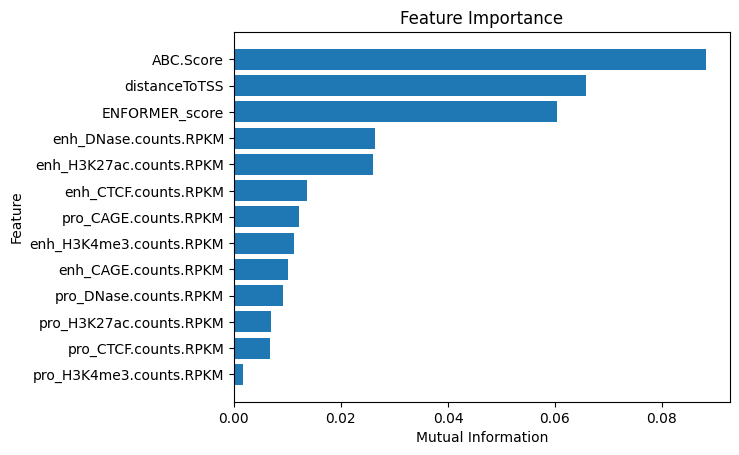

In [42]:
feature_columns, feature_MI = zip(*MI_results)
plt.title("Feature Importance")
plt.ylabel("Feature")
plt.xlabel("Mutual Information")
plt.barh(feature_columns, feature_MI)
plt.gca().invert_yaxis()  # labels read top-to-bottom
plt.show()

In [106]:
chrom_test_set = ["chr1", "chr11"]

In [107]:
def run_xgboost(feature_columns, chrom_test_set, all_df, plot_auprc=True, plot_xgb_feat_importance=True):
    X_train = all_df[~all_df["chrom"].isin(chrom_test_set)][feature_columns]
    y_train = all_df[~all_df["chrom"].isin(chrom_test_set)]["Regulated"]
    X_test = all_df[all_df["chrom"].isin(chrom_test_set)][feature_columns]
    y_test = all_df[all_df["chrom"].isin(chrom_test_set)]["Regulated"]

    clf = xgb.XGBClassifier()
    clf.fit(X_train, y_train)

    precision, recall, thresholds = metrics.precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
    aupr = metrics.auc(recall, precision)

    print("AUPRC:", aupr)

    if plot_auprc:
        plt.title("Precision Recall Curve")
        plt.plot(recall, precision)
        plt.show()

    if plot_xgb_feat_importance:
        xgb.plot_importance(clf) # F score is simply the number of times the classifier split on a particular feature. 
        plt.show()

# Performance of Model using All Features

AUPRC: 0.68384734551007


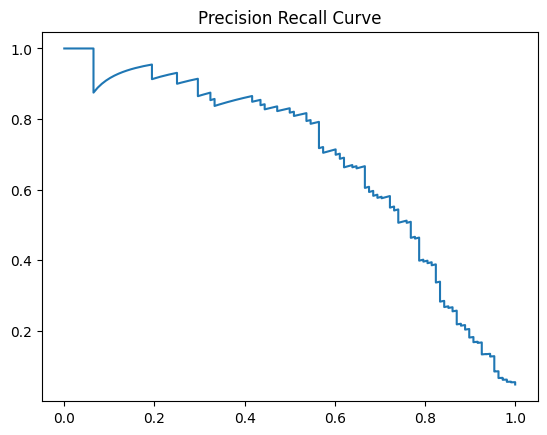

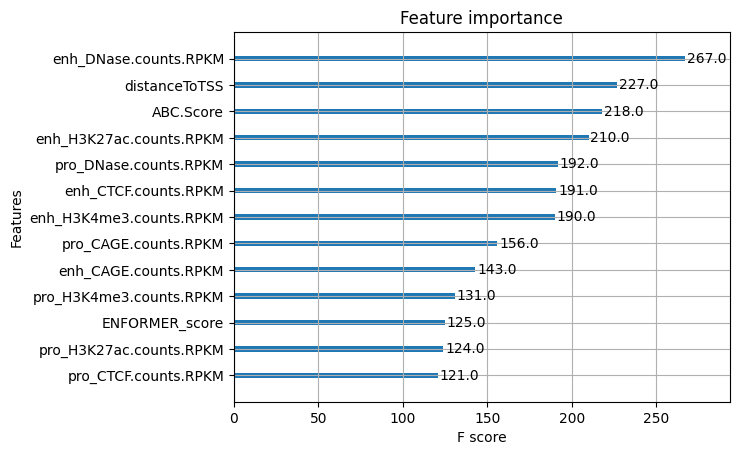

In [108]:
feature_columns = ['enh_DNase.counts.RPKM', 'enh_H3K4me3.counts.RPKM',
       'enh_CTCF.counts.RPKM', 'enh_H3K27ac.counts.RPKM',
       'enh_CAGE.counts.RPKM', 'pro_DNase.counts.RPKM',
       'pro_H3K4me3.counts.RPKM', 'pro_CTCF.counts.RPKM',
       'pro_H3K27ac.counts.RPKM', 'pro_CAGE.counts.RPKM', 'ABC.Score',
       'ENFORMER_score', 'distanceToTSS']

run_xgboost(feature_columns, chrom_test_set, all_df)

# Using Distance, ABC, ENFORMER_score 
Top 3 features ranked by Mutual Information

AUPRC: 0.512236923012344


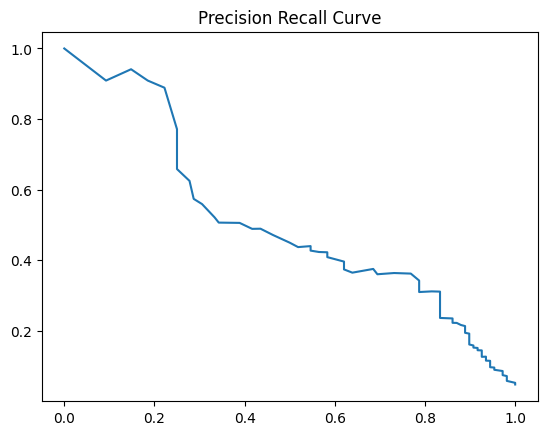

In [109]:
# Distance Only

feature_columns = ['distanceToTSS']
run_xgboost(feature_columns, chrom_test_set, all_df, plot_xgb_feat_importance=False)

AUPRC: 0.5873036383864056


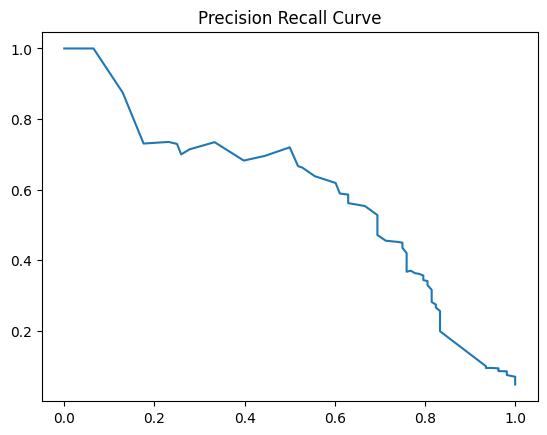

In [110]:
# ABC Only

feature_columns = ['ABC.Score']
run_xgboost(feature_columns, chrom_test_set, all_df, plot_xgb_feat_importance=False)

AUPRC: 0.4431662891908927


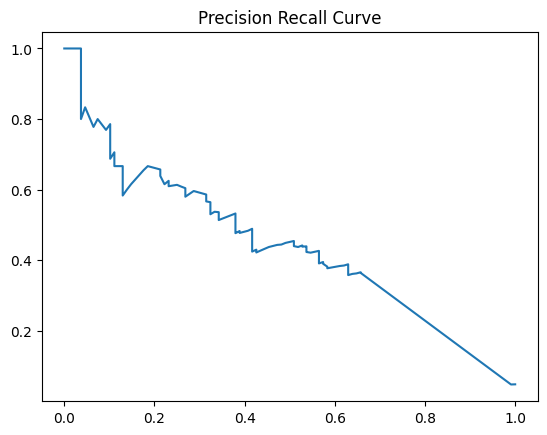

In [111]:
# ENFORMER score only

feature_columns = ['ENFORMER_score']
run_xgboost(feature_columns, chrom_test_set, all_df, plot_xgb_feat_importance=False)

# notice the straight decreasing line portion
    # that's because for candidate Enh/Pro pairs that are too distant, they exceed the ENFORMER model window. In that case the ENFORMER model can only give a score of 0
    # any model using this feature alone will therefore just give a negative verdict if it encounter this case 
    # and so it will then receive FN and TN at a constant rate 

0.9542805916629314


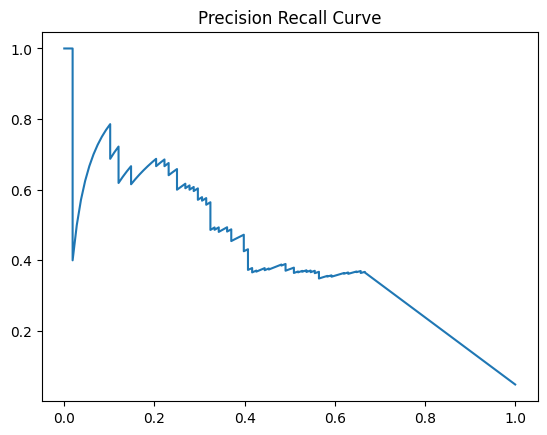

0.4190235294625503


In [127]:
# For some reason when we use Logistic Regression instead of xgboost
X_train = all_df[~all_df["chrom"].isin(chrom_test_set)][["ENFORMER_score"]]
y_train = all_df[~all_df["chrom"].isin(chrom_test_set)]["Regulated"]
X_test = all_df[all_df["chrom"].isin(chrom_test_set)][["ENFORMER_score"]]
y_test = all_df[all_df["chrom"].isin(chrom_test_set)]["Regulated"]

clf = sklearn.linear_model.LogisticRegression(random_state=0).fit(X_train, y_train)
print(clf.score(X_test, y_test))

precision, recall, thresholds = metrics.precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
aupr = metrics.auc(recall, precision)

plt.title("Precision Recall Curve")
plt.plot(recall, precision)
plt.show()

print(aupr)

# The auprc is not shabby

In [119]:
# paired features

feature_columns = ['ABC.Score', 'distanceToTSS']
print(feature_columns)
run_xgboost(feature_columns, chrom_test_set, all_df, plot_auprc=False, plot_xgb_feat_importance=False)

feature_columns = ['ABC.Score', 'ENFORMER_score']
print(feature_columns)
run_xgboost(feature_columns, chrom_test_set, all_df, plot_auprc=False, plot_xgb_feat_importance=False)


feature_columns = ['distanceToTSS', 'ENFORMER_score']
print(feature_columns)
run_xgboost(feature_columns, chrom_test_set, all_df, plot_auprc=False, plot_xgb_feat_importance=False)

['ABC.Score', 'distanceToTSS']
AUPRC: 0.5634048584500485
['ABC.Score', 'ENFORMER_score']
AUPRC: 0.5849635187034573
['distanceToTSS', 'ENFORMER_score']
AUPRC: 0.49404601433723616


# Using Raw RPKM counts only

AUPRC: 0.17340574863986352


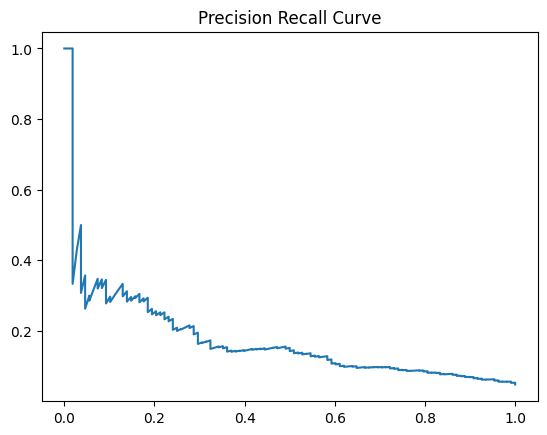

In [113]:
feature_columns = ['enh_DNase.counts.RPKM', 'enh_H3K4me3.counts.RPKM',
       'enh_CTCF.counts.RPKM', 'enh_H3K27ac.counts.RPKM',
       'enh_CAGE.counts.RPKM', 'pro_DNase.counts.RPKM',
       'pro_H3K4me3.counts.RPKM', 'pro_CTCF.counts.RPKM',
       'pro_H3K27ac.counts.RPKM', 'pro_CAGE.counts.RPKM']

run_xgboost(feature_columns, chrom_test_set, all_df, plot_xgb_feat_importance=False)

# ABC Score + Distance + DNase + H3K27ac + ENFORMER
DNase and H3K27ac (optionally) are used in calculation of ABC score. So in practice, if we have ABC score, we had to have DNase and possibly H3K27ac also.
Since these appear to be somewhat important feature, we might as well include them

AUPRC: 0.6334482989319405


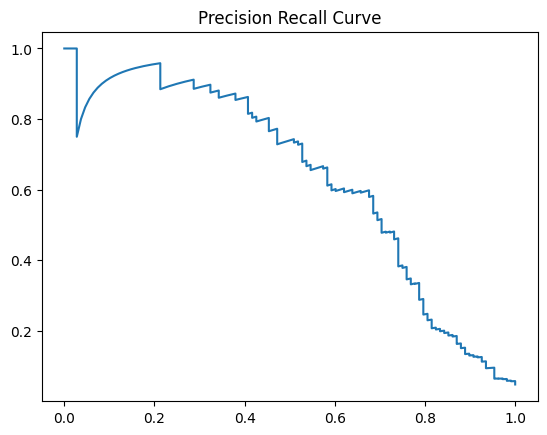

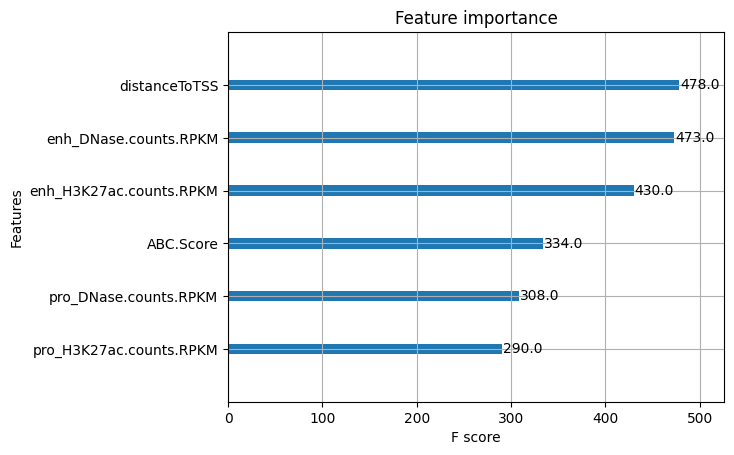

In [115]:
feature_columns = ["ABC.Score", "distanceToTSS", "enh_DNase.counts.RPKM", "enh_H3K27ac.counts.RPKM", "pro_H3K27ac.counts.RPKM", "pro_DNase.counts.RPKM"]

run_xgboost(feature_columns, chrom_test_set, all_df)

In [116]:
# might as well include ENFORMER score since it is a sequence-only model so effectively its free
# however, for it to live up to its paper's claim to Cell-type specificity, we need to retrain the model on Cell-type CAGE-seq
# we find that it makes no impact on performance
    # And this is because the model is limited to predicting EPI for candidate pairs within 114kbp (roughly 10% of this dataset)
    # Despite this, the ENFORMER model has potential on a benchmark dataset of closer EPI candidates 

feature_columns = ["ABC.Score", "distanceToTSS", "enh_DNase.counts.RPKM", "enh_H3K27ac.counts.RPKM", "pro_H3K27ac.counts.RPKM", "pro_DNase.counts.RPKM", "ENFORMER_score"]

run_xgboost(feature_columns, chrom_test_set, all_df, plot_auprc=False, plot_xgb_feat_importance=False)

AUPRC: 0.635273534530563


# Conclusions
In terms of Mutual Information (Correlation betweeen Continuous feature and Binary label)
- Distance to transcription start site is the one of the most informative feature in determining EPI (better than most other seq's alone)
- However, by itself its performance is still inadequate
- ABC Score is the only epigenetic feature that beats out Distance alone 

Distance + ABC Score yields moderately good model performance
Distance + ABC Score + Epigenetic features used to calculate ABC Score yields very good model performance
- This is good because it means we only two seq's experiments (DNase and H3K27ac)
  - In practise, ABC Score can be calculated with DNase only, so even DNase by itself could be sufficient

ENFORMER model is limited by its window size and so is quite useless under this benchmark dataset
- Despite being well correlated with the target label (i.e. is EPI genuine interaction) as seen by high MI, we see it is mostly discarded by the XgBoost model.

We find rapidly diminishing returns upon naively adding new epigenetic features
- Looking at the Mutual Information of each epigenetic feature, it is quite dismal
- Further, all the epigenetic features put together fail to outperform distance alone

I suspect that these features can still be useful, provided there is some other ABC-like model to transform the epigenetic feautures in a sensible (domain knowledge needed) way. 
  - For example, CTCF can act as Enhancer in its own right but also is found near loop anchors which can be surprisingly far from interacting EP pairs 
  - As it stands, the CTCF feature in this benchmark is calculated by a simple overlap with the candidate pairs which may miss that nuance